In [1]:
import sys, os
sys.path.append('../../')
import matplotlib.pyplot as plt 
import numpy as np
import os, json, cv2, random
import torch
import yaml 
# from google.colab.patches import cv2_imshow
import torch
import detectron2
from foundations.ovd.config import add_ovd_config
from foundations.ovd.modeling.utils import reset_cls_test
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
# CLIP library 
import clip

In [2]:
with open('../../foundations/configs/coco/COCO_OVD_Base_PIS.yaml') as f:
    className = yaml.load(f, Loader=yaml.FullLoader)
    
def dump_clip_embeddings(vocabulary, prompt='a photo of'):
    sentences = ['a photo of a {}'.format(x) for x in vocabulary]
    device = "cuda"
    model, preprocess = clip.load("ViT-B/32", device=device)
    text = clip.tokenize(sentences).to(device)
    with torch.no_grad():
      text_features = model.encode_text(text).float().T
    # text_features = text_features.cpu()
    return text_features
    
print("Done.")

Done.


In [3]:
# Modify the detectors vocabulary

# Choose from one of the provided set of vocabulary
BUILDIN_CLASSIFIER = {
    'lvis': '../../foundations/weights/zeroshot_weights/lvis_v1_clip_a+photo+cname.npy',
    'coco': '../../foundations/weights/zeroshot_weights/coco_clip_a+photo+cname.npy',
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'coco': 'coco_2017_val',
}

In [4]:
cfg = get_cfg()
add_ovd_config(cfg)
model = 'coco'
if model == 'coco':
    cfg.merge_from_file("../../foundations/configs/coco/COCO_OVD_RKD_PIS_WeightTransfer_8x.yaml")
    cfg.MODEL.WEIGHTS = 'https://github.com/hanoonaR/object-centric-ovd/releases/download/v1.0/coco_ovd_rkd_pis_weighttransfer_8x.pth'
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.65  # set threshold for this model
    cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = '../../foundations/weights/zeroshot_weights/coco_clip_a+photo+cname.npy'

elif model =='lvis':
    cfg.merge_from_file("../../foundations/configs/lvis/LVIS_OVD_RKD_PIS_WeightTransfer_8x.yaml")
    cfg.MODEL.WEIGHTS = 'https://github.com/hanoonaR/object-centric-ovd/releases/download/v1.0/lvis_ovd_rkd_pis_weighttransfer_8x.pth'
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set threshold for this model
    cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = '../../foundations/weights/zeroshot_weights/lvis_v1_clip_a+photo+cname.npy'
    
cfg.MODEL.ROI_BOX_HEAD.IGNORE_ZERO_CATS = False
cfg.MODEL.ROI_BOX_HEAD.USE_FED_LOSS = False
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True
predictor = DefaultPredictor(cfg)

The checkpoint state_dict contains keys that are not used by the model:
  roi_heads.box_predictor.freq_weight


In [25]:
# image = cv2.imread('./results/rgb_img.png')
# # save image to npy file.
# np.save('./results/rgb_img.npy', image)

Predicted label:  []


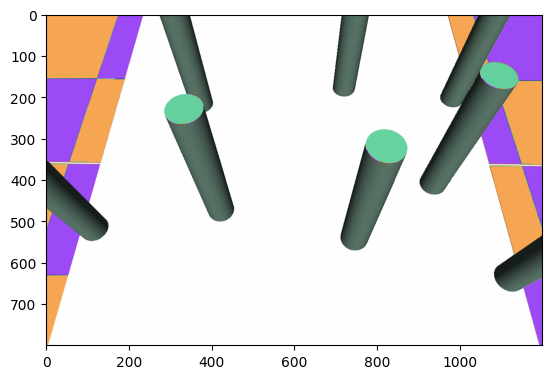

In [56]:
# Given scene 
# image_1 = np.load('../miscellaneous/color_test_w_knife.npy')
image_1 = np.load('./results/rgb_img.npy')

vocabulary = 'custom'
metadata = MetadataCatalog.get("my_dataset")
metadata.thing_classes = ['apple', 'bottle', 'spoon', 'fork', 'knife', 'box'] # add your own vocabulary for the detector
classifier = dump_clip_embeddings(metadata.thing_classes)
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)

# Reset visualization threshold
# custom_image = np.load('../miscellaneous/color_test_wo_knife.npy')
custom_image = np.load('./results/rgb_img.npy')
output_score_threshold = 0.5
outputs = predictor(custom_image*255)
v = Visualizer(custom_image[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1]+custom_image)

detected_class_indexes = outputs["instances"].to("cpu").pred_classes.tolist()
pred_class_names2 = list(map(lambda x: metadata.thing_classes[x], detected_class_indexes))
print("Predicted label: ", pred_class_names2)